In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

from utils import scale_back, merge, save_concat_images
from dataset import TrainDataProvider, InjectDataProvider, NeverEndingLoopingProvider
from ops import conv2d, deconv2d, lrelu, fc, batch_norm
from ops import init_embedding, embedding_lookup, conditional_instance_norm
from models import Encoder, Decoder, Discriminator, Generator
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_dir = './data/'
batch_size = 32
img_size = 64
fonts_num = 47

data_provider = TrainDataProvider(data_dir, filter_by=range(fonts_num))
total_batches = data_provider.compute_total_batch_num(batch_size)
print('batch size:', batch_size)
print('total batches:', total_batches)

train_batch_iter = data_provider.get_train_iter(batch_size)

unpickled total 86423 examples
unpickled total 21677 examples
filter by label -> range(0, 47)
train examples -> 86423, val examples -> 21677
batch size: 32
total batches: 2701


In [3]:
for bid, batch in enumerate(train_batch_iter):
    labels, codes, batch_images = batch
    break
    
print('label:', len(labels))
print('image size:', batch_images.shape, type(batch_images))

label: 32
image size: torch.Size([32, 2, 64, 64]) <class 'torch.Tensor'>


In [4]:
fonts_num = 47
embedding_dim = 128
embeddings = init_embedding(fonts_num, embedding_dim)
embedding_ids = labels
embeddings.shape, len(embedding_ids)

(torch.Size([47, 1, 1, 128]), 32)

In [5]:
real_target = batch_images[:, 0, :, :].view([batch_size, 1, img_size, img_size])
real_source = batch_images[:, 1, :, :].view([batch_size, 1, img_size, img_size])

In [6]:
En = Encoder()
De = Decoder()
fake_target, encoded_images = Generator(real_target, En, De, embeddings, embedding_ids)

In [7]:
En

Encoder(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  )
  (conv2): Sequential(
    (0): LeakyReLU(negative_slope=0.2)
    (1): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): LeakyReLU(negative_slope=0.2)
    (1): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): LeakyReLU(negative_slope=0.2)
    (1): Conv2d(256, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv5): Sequential(
    (0): LeakyReLU(negative_slope=0.2)
    (1): Conv2d(512, 512, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, af

In [8]:
De

Decoder(
  (deconv1): Sequential(
    (0): LeakyReLU(negative_slope=0.1)
    (1): ConvTranspose2d(640, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
  )
  (deconv2): Sequential(
    (0): LeakyReLU(negative_slope=0.1)
    (1): ConvTranspose2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
  )
  (deconv3): Sequential(
    (0): LeakyReLU(negative_slope=0.1)
    (1): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.5)
  )
  (deconv4): Sequential(
    (0): LeakyReLU(negative_slope=0.1)
    (1): ConvTranspose2d(1024, 512, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (2): BatchNorm2d(512, eps=1e-0

torch.Size([32, 1, 64, 64])


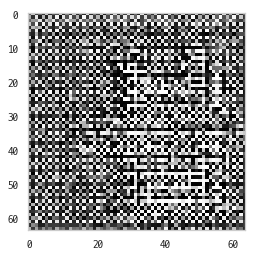

In [9]:
print(fake_target.shape)
plt.imshow(fake_target[0][0].data, cmap='gray')
plt.grid()
plt.show()

In [10]:
encoded_images.shape

torch.Size([32, 512, 1, 1])

In [11]:
D = Discriminator(category_num=fonts_num)

In [12]:
real_TS = torch.cat([real_source, real_target], dim=1)
fake_TS = torch.cat([real_source, fake_target], dim=1)
real_TS.shape, fake_TS.shape

(torch.Size([32, 2, 64, 64]), torch.Size([32, 2, 64, 64]))

In [13]:
fake_score, fake_score_logit, fake_cat_logit = D(fake_TS)

In [14]:
fake_score.shape, fake_score_logit.shape, fake_cat_logit.shape

(torch.Size([32, 1]), torch.Size([32, 1]), torch.Size([32, 47]))

In [15]:
embedding_ids

[35,
 11,
 6,
 26,
 22,
 30,
 17,
 39,
 23,
 4,
 14,
 35,
 0,
 9,
 31,
 20,
 22,
 27,
 26,
 3,
 35,
 16,
 29,
 31,
 6,
 28,
 3,
 36,
 14,
 13,
 30,
 10]

In [16]:
true_category = np.eye(fonts_num)[embedding_ids]
true_category[-2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])